In [11]:
!conda install matplotlib --yes

Channels:
 - defaults
 - nvidia
 - pytorch
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: \ 

## Package Plan ##

  environment location: /home/matinubuntu/miniconda3/envs/hf-diffusers

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    contourpy-1.2.1            |   py39hdb19cb5_1         245 KB
    fonttools-4.55.3           |   py39h5eee18b_0         2.4 MB
    kiwisolver-1.4.4           |   py39h6a678d5_0          76 KB
    matplotlib-3.9.2           |   py39h06a4308_1           7 KB
    matplotlib-base-3.9.2      |   py39hbfdbfaf_1         7.0 MB
    pyparsing-3.2.0            |   py39h06a4308_0         421 KB
    unicodedata2-15.1.0        |   py39h5eee18b_1         519 KB
    ------------------------------------------------------------
                                           Total:        10.7 MB


In [11]:
!conda install -c conda-forge jupyterthemes --yes

Channels:
 - conda-forge
 - defaults
 - nvidia
 - pytorch
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: - 

# All requested packages already installed.



In [13]:
jupyterthemes

NameError: name 'jupyterthemes' is not defined

In [21]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True)
image = ddpm(num_inference_steps=25).images[0]
image.save("output.png")

OSError: Could not find the necessary `safetensors` weights in {'diffusion_pytorch_model.safetensors', 'diffusion_pytorch_model.bin'} (variant=None)

In [20]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True)

In [3]:
scheduler.set_timesteps(50)

In [4]:
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [19]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cpu")

TypeError: randn() received an invalid combination of arguments - got (tuple, device=str, use_safetensors=bool), but expected one of:
 * (tuple of ints size, *, torch.Generator generator, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.Generator generator, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [1]:
sample_size

NameError: name 'sample_size' is not defined

In [17]:
from PIL import Image

input = noise
denoised_images = []

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample
    image = (input / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).numpy()
    image = Image.fromarray(image)
    denoised_images.append(image)

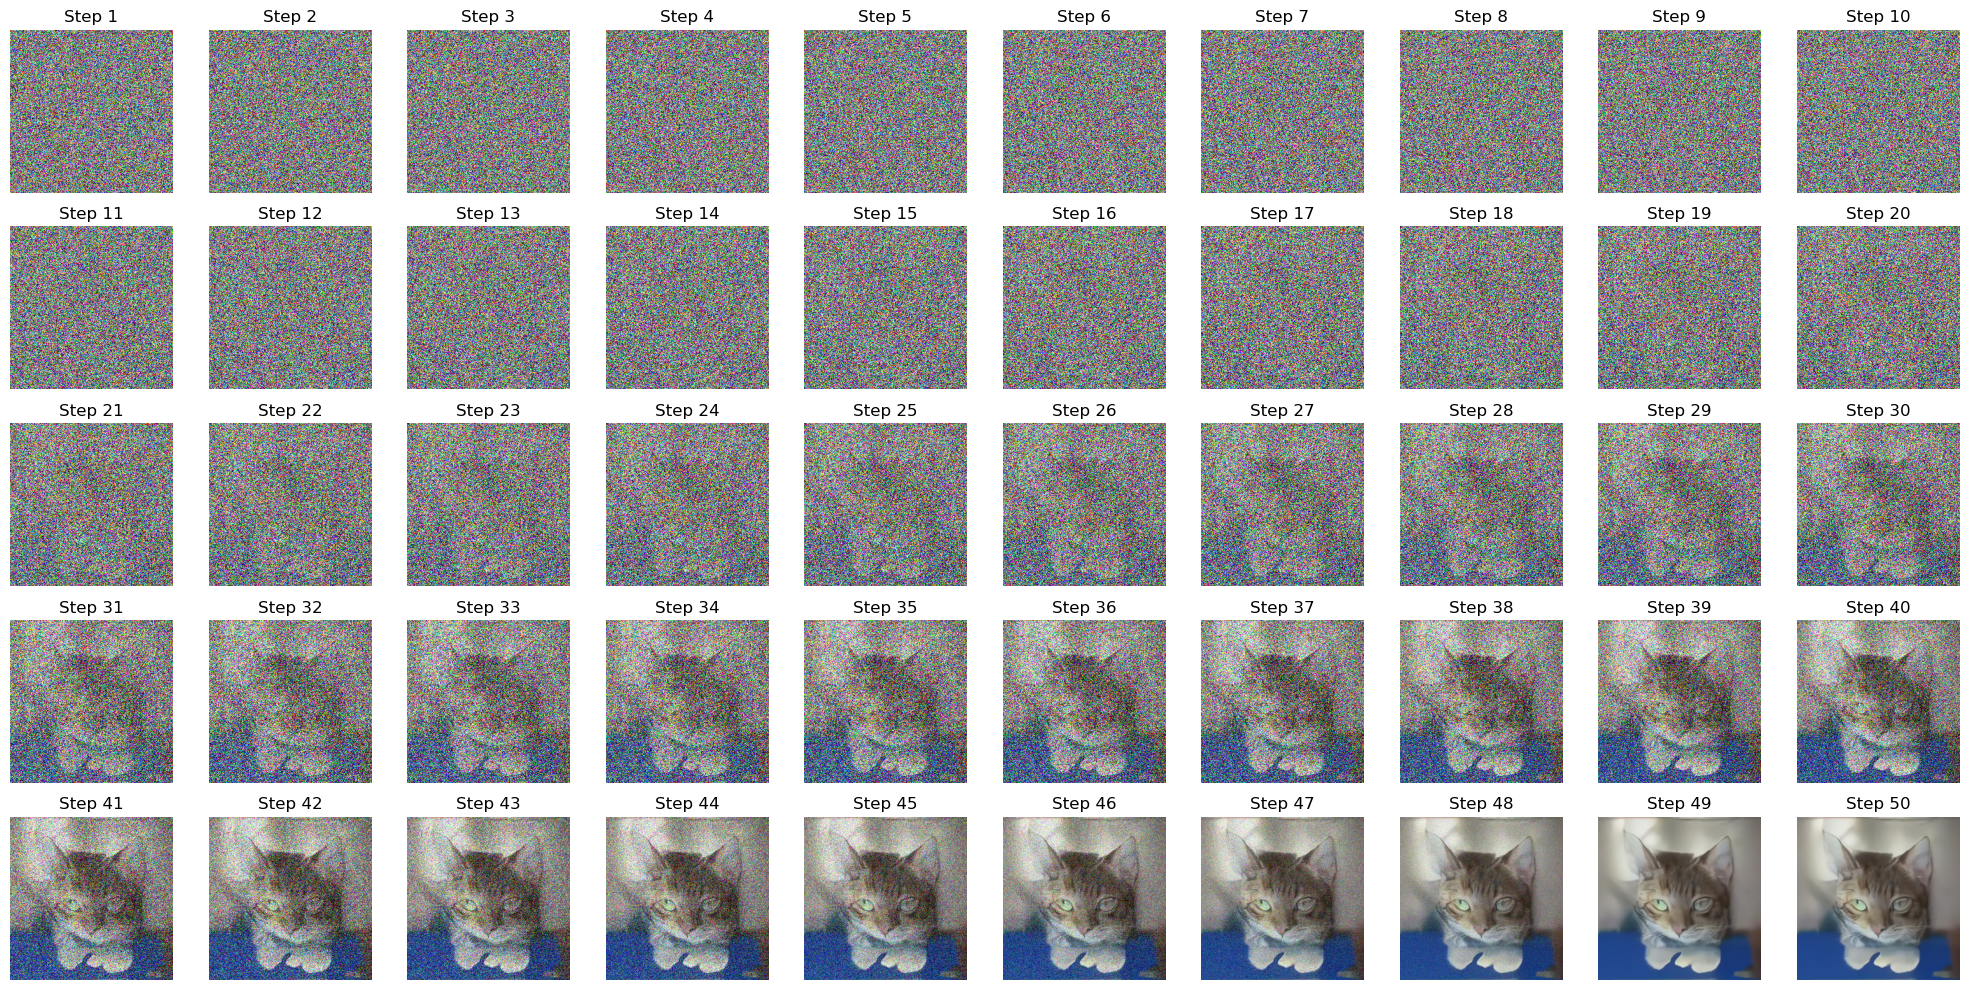

In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# image = (input / 2 + 0.5).clamp(0, 1).squeeze()
# image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).numpy()
# image = Image.fromarray(image)
# image

fig, axes = plt.subplots(5, 10, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    if i < len(denoised_images):
        ax.imshow(denoised_images[i])
        ax.set_title(f"Step {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [91]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True).to("cpu")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True)

In [92]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [93]:
prompt = ["a photograph of an astronaut riding a horse"]
height, width = 512, 512
num_inference_steps = 25
guidance_scale = 7.5
generator = torch.manual_seed(0)
batch_size = len(prompt)

In [94]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids)[0]
text_embeddings.shape

torch.Size([1, 77, 768])

In [95]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids)[0]
uncond_embeddings.shape

torch.Size([1, 77, 768])

In [96]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
text_embeddings.shape

torch.Size([2, 77, 768])

In [97]:
2 ** (len(vae.config.block_out_channels) - 1) == 8

True

In [98]:
latents = torch.randn((batch_size, unet.config.in_channels, height // 8, width // 8), generator=generator).to("cpu")
latents.shape

torch.Size([1, 4, 64, 64])

In [99]:
latents = latents * scheduler.init_noise_sigma

In [100]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [117]:
images = [] # list of sampled images

noise_strength = 0.2

for _ in range(16):
    with torch.no_grad():
        # noisy_latents = latents + noise_strength * torch.randn_like(latents)
        noise = noise_strength * torch.randn_like(latents)
        noisy_latents = latents + noise
        noisy_latents = 1 / 0.18215 * noisy_latents
        # Debug: Print noise stats (should vary)
        print(f"Noise mean: {noise.mean().item()}, std: {noise.std().item()}")
        image = vae.decode(noisy_latents).sample
        image = (image / 2 + 0.5).clamp(0, 1).squeeze()
        image = (image.permute(1, 2, 0)* 255).to(torch.uint8).numpy()
        images.append(image)

Noise mean: 0.0029631610959768295, std: 0.20003317296504974
Noise mean: 0.0004669441841542721, std: 0.19921839237213135
Noise mean: 0.0009592518908903003, std: 0.20011457800865173
Noise mean: -0.00232927524484694, std: 0.19932076334953308
Noise mean: 0.0025728680193424225, std: 0.2001628577709198
Noise mean: 0.00010412544361315668, std: 0.19963638484477997
Noise mean: 0.00025978998746722937, std: 0.20008112490177155
Noise mean: -0.0008219484006986022, std: 0.19953547418117523
Noise mean: -0.0017019842052832246, std: 0.20042423903942108
Noise mean: -0.00018027029000222683, std: 0.19909144937992096
Noise mean: 0.002249589655548334, std: 0.20147337019443512
Noise mean: -0.0003662689123302698, std: 0.20012645423412323
Noise mean: -0.0009352209744974971, std: 0.19884493947029114
Noise mean: -0.0007044274243526161, std: 0.19964934885501862
Noise mean: 0.000429913547122851, std: 0.19846709072589874
Noise mean: -0.001832863548770547, std: 0.1988404095172882


In [63]:
import matplotlib.pyplot as plt

In [113]:
len(images)

16

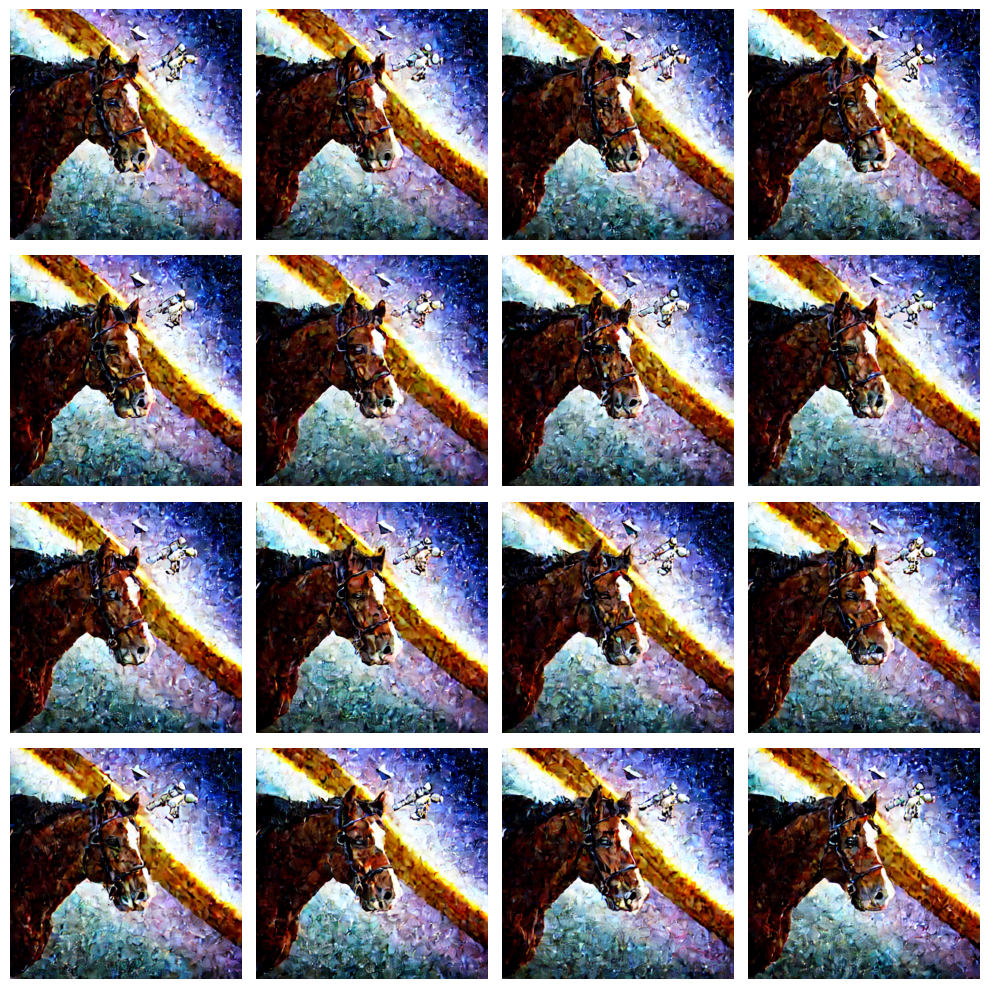

In [116]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

# Plot each image
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')  # Hide axes

# Display the grid of images
plt.tight_layout()
plt.show()